## Imports and dependencies

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import nonzero
# plt.rcParams.update({'text.usetex':False})

import flavio
import flavio.plots
import pandas as pd

import matplotlib.ticker as tck

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

from sklearn.metrics import r2_score, accuracy_score

# EXPERIMENT 1 - Distinguish data generated from Monte-Carlo from random noise.
**AIM -** We want to be able to distinguish two datasets from each other. One is generated using a probability function and therefore has a distinct distribution, the other is random noise. 

**METHOD -** Generate two datasets with the same number of values and the same range of values. The ordered dataset is generated as a circle with higher density towards the middle. The range of the values are $[-1,1]$. Try a few different algorithms (MLP, Decision tree, Boosted trees) and compare them to guessing. 

**RESULTS -** By simply looking at each data point we achieve an accuracy of around 0.68. This is not a good result considering how dramatically different the two datasets are. It is easy to see why this happens from the scatter plot: many data points are in the same place regardless of which dataset they are from.

For such a simple problem it is possible to guess the decision boundary very easily and so the guess performs as well as both the MLP and the boosted trees. Worst is the single decision tree. 

## Read data

In [5]:
# circle data is a monte carlo dataset generated to follow a parabolic probability distribution (i.e. a circle which is denser in the middle)
circle = pd.read_csv('xy_circle.csv', index_col=0)

# random data is simply a uniform distribution in the same range as the circle
rnd = pd.read_csv('xy_random.csv', index_col=0)

circle['dataset'] = ['circle'] * len(circle)
rnd['dataset'] = ['random'] * len(rnd)

## Visualise Data

<AxesSubplot:>

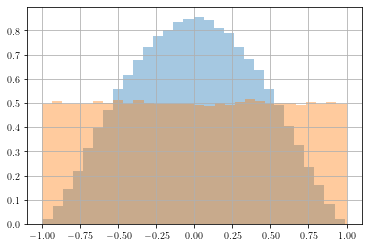

In [6]:
ax = circle['x'].hist(density=True,alpha=0.4, bins=30)
rnd['x'].hist(ax=ax,density=True,alpha=0.4, bins=30)

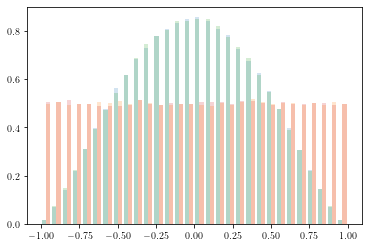

In [7]:
plt.hist([circle['x'], rnd['x']], density=True, bins=30, alpha=0.2)
plt.hist([circle['y'], rnd['y']], density=True, bins=30, alpha=0.2)
plt.show()

(fig 1.) Visualisation of the dataset.

In [8]:
combined = pd.concat([circle,rnd])

In [9]:
# Create train test split with 25 % of data in test. Shuffle is True.
x_train, x_test, y_train, y_test = train_test_split(combined[['x', 'y']], combined['dataset'])
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

### Run different classifiers on the raw dataset - no binning

In [91]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

MLP classifier

In [89]:
mlpCl = MLPClassifier().fit(x_train, y_train)
print(f'Accuracy MLP: {mlpCl.score(x_test, y_test):.4}')

Accuracy MLP: 0.684


Decision tree classifier

In [90]:
treeCl = DecisionTreeClassifier().fit(x_train, y_train)
print(f'Accuracy Decision Tree: {treeCl.score(x_test, y_test):.4}')

Accuracy Decision Tree: 0.6042


Ada boosted trees

In [94]:
boostedTreeCl = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4), n_estimators=50).fit(x_train, y_train)
print(f'Accuracy Decision Tree: {boostedTreeCl.score(x_test, y_test):.4}')

Accuracy Decision Tree: 0.6817


Guessing

In [88]:
# Guessing that the data is random if further than 0.75 from origin
pred = np.where(((x_test['x']**2 + x_test['y'] **2) > 0.75), 1, 0)
print(f'Accuracy strategic guess: {accuracy_score(pred, y_test):.4}')

Accuracy strategic guess: 0.6751


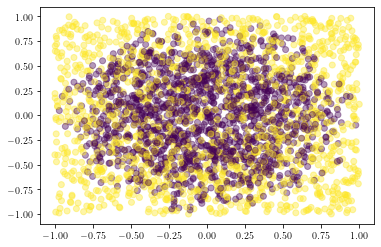

In [19]:
plt.scatter(x_train['x'].iloc[:3000], x_train['y'].iloc[:3000], c=y_train[:3000], alpha=0.4)

In [56]:
y_test

array([1, 1, 1, ..., 0, 0, 1])

(fig. 2) Shows the datasets plotted in 2d. We see that there is a lot of overlap in the data points. This illustrates why the algorithm cannot determine if a SINGLE point belongs to either dataset.

# EXPERIMENT 2 - Use binning to extract global information about the distribution of data.
**AIM -** To improve the performance of the classifier by incorporating global information about the distribution of data.

**METHOD -** Instead of passing each point individually to the algorithm, we first compute a histogram of the data. Then the value at each bin is fed to the algorithm. This also has the advantage that we can easily reweight the distribution down the line. One issue here is that for each dataset we only get one data point for the algorithm. This is resolved by sampling the original distribution to create subsets of the distribution. This is illustrated in fig. 3. Performing sampling yields as many data points as we want. (Is this bootstrapping?)

**RESULTS -** By only sampling 100 points we now achieve 96% accuracy.

## Sampling
Take a sample of circle distribution to train on

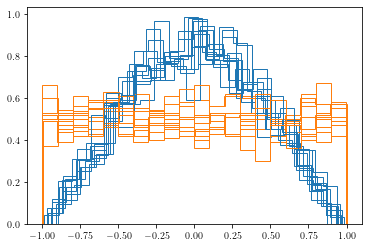

In [95]:
for _ in range(10):
    plt.hist(circle.sample(1000)['x'], alpha=1, histtype='step', density=True, bins=20, color='tab:blue')
    plt.hist(rnd.sample(1000)['x'], alpha=1, histtype='step', density=True, bins=20, color='tab:orange')

(fig. 3) We see that at 1000 samples there is a very clear visible difference between the two datasets.

In [96]:
# Perform the sampling for circle and random data

# define parameters for the sampling procedure
sample_size = 100
n_bins = 10
bin_edges = np.linspace(-1,1,n_bins + 1)
middles = (bin_edges[:-1] + bin_edges[1:]) / 2
features = [f'x{i}' for i in range(10)]

# create a dataframe that holds the resulting histogram information
histogram_dataset = pd.DataFrame(columns=features+['y'])

# each iteration creates two datapoints
for i in range(3000):
    # do circle
    circle_sample = circle.sample(sample_size)['x']
    bin_values, bin_edges = np.histogram(circle_sample, bins=bin_edges, density=True)
    row = {c:v for c,v in zip(features, bin_values)}
    row['y'] = 'circle'
    histogram_dataset = histogram_dataset.append(row, ignore_index=True)
    
    # do random
    rnd_sample = rnd.sample(sample_size)['x']
    bin_values, bin_edges = np.histogram(rnd_sample, bins=bin_edges, density=True)
    row = {c:v for c,v in zip(features, bin_values)}
    row['y'] = 'rnd'
    histogram_dataset = histogram_dataset.append(row, ignore_index=True)


## MLP - distinguish between datasets

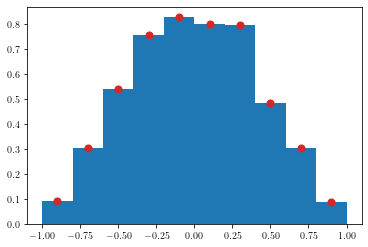

In [28]:
# visualise the histogram data
circle_sample = circle.sample(2000)['x']
bin_values, _ = np.histogram(circle_sample, bins=bin_edges, density=True)
middles = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.hist(circle_sample, bins=bin_edges, density=True)
plt.scatter(middles, bin_values, c='tab:red', marker='.', s=200, zorder=10)

In [97]:
# perform split before training
x_train, x_test, y_train, y_test = train_test_split(histogram_dataset[features], histogram_dataset[['y']])

In [98]:
# encode the labels
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [99]:
# run classifier
mlp_clf = MLPClassifier()
mlp_clf.fit(x_train, y_train)

# evaluate classifier
mlp_clf.score(x_test, y_test)

1.0

<AxesSubplot:>

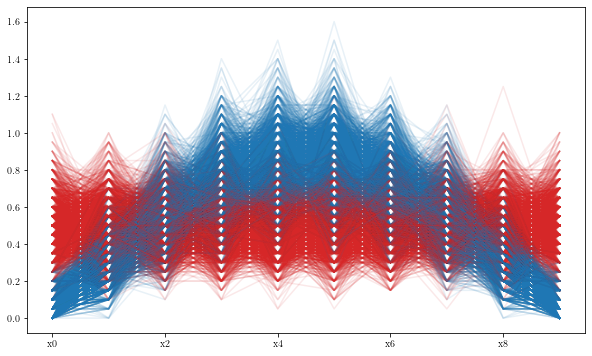

In [101]:
# visualise the dataset
fig, ax = plt.subplots(figsize=(10,6))
x_train.iloc[:].T.plot(color=np.where(y_train[:], 'tab:red', 'tab:blue'), ax=ax, legend=False, alpha=0.1)

(fig. 4) Visualisation of sampled data. The red is the random data and the blue is the circle. This shows only the x axis.

## COMMENTS
Using te histogram data as the input into an MLP, we can easily distinguish between the data from the circle and the random distribution, even when the samples are only around 100 points. One possible issue here is that the model might be over fitting on certain nodes. For example, node $x_0$ and $x_{10}$ would both be very good at telling the two datasets apart on their own, the rest of the network is essentially redundant. This problem is simply too easy even with the large amount of noise in the small samples.

#  EXPERIMENT 3 - 2D Gaussian case with different coefficients
**AIM -** Determine the coefficient used when generating a Gaussian distribution of the points. This is more similar to our actual problem. There is a probability distribution defined by 
\begin{equation}
f(x,y) = e^{-ax^2-by^2}
\end{equation}
and by changing $a$ and $b$ we change the shape of the distribution. The aim here is to find $a$ and $b$ using nothing but the resulting distribution of data.

**METHOD -** Use the same sampling method as before but use a regressor instead of a classifier. We generate datasets for uniform random $a, b \in [0, 5]$. This creates a continuous value for the algorithm to train against. Instead of generating new datasets we simply reweight with new a and b values.

**RESULTS -** Using 100 samples, the score of the regressor is around 90% i.e. $R^2\approx 0.9$. This becomes close to 99% when we increase the sample size.

In [102]:
# define the gaussian 2d distribution
def gauss_2d(x, y, a, b):
    return np.exp(- a * (x ** 2) - b * (y ** 2))

In [103]:
# import monte-carlo data
gaussian = pd.read_csv('xy_gauss_11.csv', index_col=0)

## Generate sample

In [104]:
# generate histogram data of distribution
sample_size = 100
n_bins = 10
bin_edges = np.linspace(-1,1,n_bins + 1)
middles = (bin_edges[:-1] + bin_edges[1:]) / 2
features_x = [f'x{i}' for i in range(n_bins)]
features_y = [f'y{i}' for i in range(n_bins)]
targets = ['a', 'b']

dataset_g = pd.DataFrame(columns=features_x + features_y + targets)

for a, b in tqdm(np.random.uniform(0,5, (1000, 2))):

    # generate new sample
    new_sample = gaussian.sample(sample_size)

    # compute weight for rescaling
    new_J = new_sample.apply(lambda r: gauss_2d(r['x'], r['y'], a, b), axis=1)
    w = new_J / new_sample['R']

    # compute weighted histogram
    bin_values_x, _ = np.histogram(new_sample['x'], bins=bin_edges, density=True, weights=w)
    bin_values_y, _ = np.histogram(new_sample['y'], bins=bin_edges, density=True, weights=w)

    # create dataset row
    row = {c:v for c,v in zip(features_x + features_y, bin_values_x.tolist() + bin_values_y.tolist())}
    row['a'] = a
    row['b'] = b
    dataset_g = dataset_g.append(row, ignore_index=True)


100%|██████████| 1000/1000 [00:18<00:00, 54.45it/s]


In [105]:
dataset_g

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,y2,y3,y4,y5,y6,y7,y8,y9,a,b
0,0.172897,0.245017,0.611365,0.478036,1.316477,0.651414,0.523176,0.304773,0.388177,0.308668,...,0.473723,0.592856,1.031835,1.368917,0.495535,0.517019,0.211300,0.036028,1.662547,4.081107
1,0.059259,0.116221,0.433213,0.677401,1.624558,1.068872,0.487848,0.327450,0.131103,0.074075,...,0.749129,0.855555,0.773115,0.302222,0.696227,0.511849,0.325151,0.426621,3.820762,1.044949
2,0.026076,0.088078,0.398250,0.870168,1.170049,0.679399,1.074388,0.511786,0.152736,0.029069,...,0.618008,0.666852,0.146216,1.059742,0.439847,0.823709,0.288395,0.392469,4.877944,0.865694
3,0.047726,0.248198,0.694202,0.504201,1.223442,0.639985,0.731263,0.542451,0.311395,0.057137,...,0.841601,0.708999,0.942167,0.790973,0.715067,0.308778,0.322953,0.079885,2.761234,2.500468
4,0.173101,0.284133,0.685894,0.621387,0.982413,0.773388,0.824161,0.410484,0.245040,0.000000,...,0.247860,0.659354,0.956142,1.059090,0.719632,0.287667,0.417905,0.137469,1.786123,1.702917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.437148,0.311460,0.510719,0.577901,0.952224,0.809804,0.774981,0.220529,0.121935,0.283299,...,0.293365,0.699321,0.627341,1.050581,0.759355,0.564354,0.328846,0.179294,1.861621,2.230489
996,0.026827,0.140832,0.377145,0.902112,0.675889,1.264809,1.072396,0.288853,0.180209,0.070928,...,0.511160,0.789389,0.817674,0.981864,0.714601,0.779087,0.080277,0.066073,3.665930,3.628425
997,0.234658,0.379347,0.495929,0.508950,0.417992,1.168887,0.464506,0.631334,0.348790,0.349608,...,0.511559,0.811006,1.145042,0.770984,0.620653,0.439286,0.189624,0.164999,1.544374,2.576529
998,0.025496,0.109516,0.310647,0.940500,1.180270,1.298305,0.848356,0.191345,0.062560,0.033004,...,0.387073,0.946524,0.828752,0.856911,0.859440,0.278399,0.347925,0.153986,4.762655,1.607410


## Visualise

<AxesSubplot:>

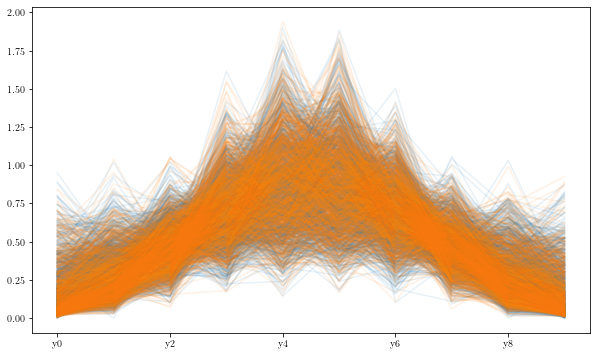

In [106]:
# visualise the data
fig, ax = plt.subplots(figsize=(10,6))
dataset_g[features_x].T.plot(color='tab:blue', ax=ax, legend=False, alpha=0.1)
dataset_g[features_y].T.plot(color='tab:orange', ax=ax, legend=False, alpha=0.1)

(fig. 5) Orange shows the y data, blue shows the x.

## MLP Regressor

In [107]:
x_train, x_test, y_train, y_test = train_test_split(dataset_g[features_x + features_y], dataset_g[targets])

In [109]:
model = MLPRegressor()
model.fit(x_train, y_train)
model.score(x_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8971232452677018

Below we can test a single scenarios just to see that it works correctly

In [110]:
# generate a single test case
a, b = 4, 2
new_sample = gaussian.sample(1000)

# compute weight for rescaling
new_J = new_sample.apply(lambda r: gauss_2d(r['x'], r['y'], a, b), axis=1)
w = new_J / new_sample['R']

# compute weighted histogram
bin_values_x, _ = np.histogram(new_sample['x'], bins=bin_edges, density=True, weights=w)
bin_values_y, _ = np.histogram(new_sample['y'], bins=bin_edges, density=True, weights=w)

# create dataset row
row = {c:v for c,v in zip(features_x + features_y, bin_values_x.tolist() + bin_values_y.tolist())}
row['a'] = a
row['b'] = b

In [115]:
a_pred, b_pred = model.predict([pd.Series(row)[features_x + features_y]])[0]
print('a = ', a_pred)
print('b = ', b_pred)

a =  4.012198256386507
b =  2.2130648496829926


# EXPERIMENT 4 - $N$-dimensional Gaussian
**AIM -** The method in experiment 3 removed the codependence of x and y by projecting the information into two 1D dataset. Here we try to keep the 2D nature of the datasets. We also use a method which could be generalised to any dimensions. This is useful since our data is 4 dimensional.

**METHOD -** Follow same procedure as before but using a d dimensional histogram. We then flatten it into 1 dimension and use as input into our model.

**RESULTS -** This method requires more data to perform as well as the previous example since the data is spread out more. The resulting score is slightly worse at $R^2\approx 0.88$. I suspect however that this method is more reliable when we get to higher dimensions and when there is more interplay between the features.

### Histogram test

In [116]:
# Test how histogram dd works.
values, _ = np.histogramdd(new_sample[['x', 'y']].values, bins=[bin_edges,bin_edges], weights=w, density=True)

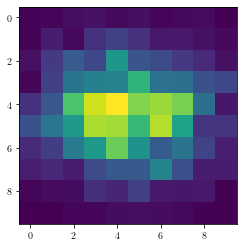

In [117]:
plt.imshow(values)

(fig. 6) 2D representation of the data. This preserves more information than the 1D projections used above.

## Sampling 

In [118]:
sample_size = 100
n_bins = 5
m_bins = 5
bin_edges_2d = [np.linspace(-1,1,n_bins + 1), np.linspace(-1,1,m_bins + 1)]
features_2d = [f'x{i}' for i in range(n_bins * m_bins)]
targets = ['a', 'b']

dataset_g_2d = pd.DataFrame(columns=features_2d + targets)

for a, b in tqdm(np.random.uniform(0,5, (1000, 2))):

    # generate new sample
    new_sample = gaussian.sample(sample_size)

    # compute weight for rescaling
    new_J = new_sample.apply(lambda r: gauss_2d(r['x'], r['y'], a, b), axis=1)
    w = new_J / new_sample['R']

    # compute weighted histogram
    values_2d, _ = np.histogramdd(new_sample[['x', 'y']].values, bins=bin_edges_2d, weights=w, density=True)

    # create dataset row
    row = {c:v for c,v in zip(features_2d, values_2d.flatten())}
    row['a'] = a
    row['b'] = b
    dataset_g_2d = dataset_g_2d.append(row, ignore_index=True)


100%|██████████| 1000/1000 [00:19<00:00, 51.64it/s]


## Fit MLP Regressor

In [119]:
x_train, x_test, y_train, y_test = train_test_split(dataset_g_2d[features_2d], dataset_g_2d[targets])

In [120]:
model = MLPRegressor(max_iter=1000, hidden_layer_sizes=100, solver='adam')
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.9013712567487344

## Comments
This procedure is very similar to image recognition (at least in the 2D case) so it could be worth looking into Convolutional Neural Networks to see if they would improve our results. I know that currently there is quite a bit of research into CNNs to use in detectors. 

# EXPERIMENT 5 - $N$-dimensional Gaussian Using Tensor Flow
**AIM -** Repeat experiment 4 but use tensorflow instead of simple MLPs

**METHOD -** 

**RESULTS -** Achieves similar but slightly worse ($R^2\approx0.86$) performance compared to MLP form sklearn

### install/import tensorflow

In [63]:
!pip install --upgrade tensorflow

  Using cached tensorflow-2.7.0-cp38-cp38-macosx_10_11_x86_64.whl (207.1 MB)


In [121]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Create test NN similar to the MLP

In [122]:
n = 25
l1 = 100
l2 = 25
out = 2
model_tf = keras.Sequential()
model_tf.add(keras.Input(shape=(n)))
model_tf.add(layers.Dense(l1, activation='relu'))  # first layer takes in n inputs and outputs to l1 nodes
# model_tf.add(layers.Dense(l2, activation='relu'))  # second layer takes in l1 inputs and outputs to l2 nodes
model_tf.add(layers.Dense(out, activation='relu'))    # last layer takes in l1 nodes and outputs to out nodes

model_tf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2600      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 2,802
Trainable params: 2,802
Non-trainable params: 0
_________________________________________________________________


In [123]:
model_tf.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)

In [124]:
history = model_tf.fit(
    x_train.values, 
    y_train.values,
    batch_size=10,
    epochs=10,
    # validation_data=(x_test, y_test)
)

Epoch 1/10
75/75 [==============================] - 0s 815us/step - loss: 3.3189 - mean_squared_error: 3.3189
Epoch 2/10
75/75 [==============================] - 0s 977us/step - loss: 1.0671 - mean_squared_error: 1.0671
Epoch 3/10
75/75 [==============================] - 0s 1ms/step - loss: 0.4995 - mean_squared_error: 0.4995
Epoch 4/10
75/75 [==============================] - 0s 1ms/step - loss: 0.3057 - mean_squared_error: 0.3057
Epoch 5/10
75/75 [==============================] - 0s 897us/step - loss: 0.2709 - mean_squared_error: 0.2709
Epoch 6/10
75/75 [==============================] - 0s 893us/step - loss: 0.2609 - mean_squared_error: 0.2609
Epoch 7/10
75/75 [==============================] - 0s 863us/step - loss: 0.2515 - mean_squared_error: 0.2515
Epoch 8/10
75/75 [==============================] - 0s 876us/step - loss: 0.2450 - mean_squared_error: 0.2450
Epoch 9/10
75/75 [==============================] - 0s 880us/step - loss: 0.2404 - mean_squared_error: 0.2404
Epoch 10/10
75

In [125]:
pred = model_tf.predict(x_test)

print(f'R^2    - {r2_score(pred, y_test.values)}')
print(f'R^2(a) - {r2_score(pred[:,0], y_test.values[:,0])}')
print(f'R^2(b) - {r2_score(pred[:,1], y_test.values[:,1])}')

R^2    - 0.8824735743244604
R^2(a) - 0.8986737803347925
R^2(b) - 0.8662733671670129


### Comments
Adding layers seems to decrease performance which is unexpected. Maybe there are not enough data points to train such large networks?

## Create NN which uses 2D input - NOT COMPLETE YET!!!

In [126]:
x_train_2d = x_train.values.reshape((x_train.shape[0],5,5))
x_test_2d = x_test.values.reshape((x_test.shape[0],5,5))
y_train_2d = y_train.values.reshape((y_train.shape[0],1,2))
y_test_2d = y_test.values.reshape((y_test.shape[0],1,2))

In [127]:
n = 5
m = 5
l1 = 10
l2 = 25
out = 2
model_tf = keras.Sequential()
model_tf.add(keras.Input(shape=(n,m)))


model_tf.add(layers.Dense(l1, activation='relu'))       # first layer takes in n inputs and outputs to l1 nodes
model_tf.add(layers.Dense(out, activation='relu'))      # last layer takes in l1 nodes and outputs to out nodes
model_tf.add(layers.Flatten())

model_tf.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 5, 10)             60        
_________________________________________________________________
dense_3 (Dense)              (None, 5, 2)              22        
_________________________________________________________________
flatten (Flatten)            (None, 10)                0         
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________


In [128]:
model_tf(np.ones((5,5)))

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[0.42348355, 0.8563853 ],
       [0.42348355, 0.8563853 ],
       [0.42348355, 0.8563853 ],
       [0.42348355, 0.8563853 ],
       [0.42348355, 0.8563853 ]], dtype=float32)>

In [129]:
model_tf.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)

In [130]:
history = model_tf.fit(
    x_train.values, 
    y_train.values,
    batch_size=10,
    epochs=10,
    # validation_data=(x_test, y_test)
)

Epoch 1/10


ValueError: in user code:

    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 train_step
        y_pred = self(x, training=True)
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:251 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected axis -1 of input shape to have value 5 but received input with shape (10, 25)


In [ ]:
pred = model_tf.predict(x_test)

print(f'R^2    - {r2_score(pred, y_test.values)}')
print(f'R^2(a) - {r2_score(pred[:,0], y_test.values[:,0])}')
print(f'R^2(b) - {r2_score(pred[:,1], y_test.values[:,1])}')

R^2    - 0.8696862614216394
R^2(a) - 0.87707971805123
R^2(b) - 0.862292805306903
